# Predicting the PRICE of items listed in Vinted #

## Importing libraries ##

In [31]:
import seaborn as sns
import sklearn as sk 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math

from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report

## Importing the dataset ##

First, I am going to load my data into the notebook. In **Final Assignment_Cleaning and Analyzing** I have cleaned my initial dataset and made some interesting analyzations. Now, I am going to make a model that would predict the price of the item. 

In [2]:
df = pd.read_csv("cleaned_vinted.csv")
df.head()

,ID,Category,Price,Size,State,Brand,Colors,Amount_Of_Pictures,Ratio
0,841147011,Dress,29.0,M / 38 / 10,Very good,Vintage,Beige,3,5.700000
1,841212517,Suit,30.0,S / 36 / 8,Very good,Vintage,Black,4,8.884615
2,836855778,Sweater,15.0,M / 38 / 10,Very good,Vintage,White,1,4.150000
3,836637612,Jacket,165.0,M / 38 / 10,Very good,genuine leather,Black,8,19.777778
4,841235285,Jacket,60.0,M / 38 / 10,Very good,Dolce & Gabbana,Light blue,6,10.444444


## Creating dummies for categorical variables ##

As you might have noticed I have a few categorical variables in my column such as category, size and state of the item. To make them actually useful when predicting the price of an item I have to convert them into dummy variables. 

In [3]:
State_dummies = pd.get_dummies(df["State"], prefix = "State").iloc[:,1:]
df = pd.concat([df, State_dummies], axis=1)
del df["State"]

In [4]:
Category_dummies = pd.get_dummies(df["Category"], prefix = "Category").iloc[:,1:]
df = pd.concat([df, Category_dummies], axis=1)
del df["Category"]

In [5]:
#Size_dummies = pd.get_dummies(df["Size"], prefix = "Size").iloc[:,1:] - I removed this because it worsens the model
#df = pd.concat([df, Size_dummies], axis=1)
del df["Size"]

In [6]:
Brand_dummies = pd.get_dummies(df["Brand"], prefix = "Brand").iloc[:,1:]
df = pd.concat([df, Brand_dummies], axis=1)
del df["Brand"]

In [7]:
#Colors_dummies = pd.get_dummies(df["Colors"], prefix = "Colors").iloc[:,1:] - I removed this because this worsens the model
#df = pd.concat([df, Colors_dummies], axis=1)
del df["Colors"]

As you can see I have created dummy variables for each categorical variable. As you might have noticed the variables Size and Colors are not been put into the dataset anymore. This is due to the model not actually being better when these variables were being used. However, this was done after the model was created and evaluated. 

In [8]:
df.head()

,ID,Price,Amount_Of_Pictures,Ratio,State_New with tags,State_New without tags,State_Satisfactory,State_Very good,Category_Athletic Wear,Category_Bag,...,Brand_sandwich,Brand_sans marque,Brand_showpo,Brand_sixames,Brand_sixtyseven,Brand_somma,Brand_stainless steel,Brand_the avocado sock,Brand_veneno,Brand_welooc
0,841147011,29.0,3,5.700000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,841212517,30.0,4,8.884615,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,836855778,15.0,1,4.150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,836637612,165.0,8,19.777778,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,841235285,60.0,6,10.444444,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Building the model ##

Before actually building the model I am going to make a correlation matrix to kind of get the idea of all the correlations. 

In [9]:
df.corr()

,ID,Price,Amount_Of_Pictures,Ratio,State_New with tags,State_New without tags,State_Satisfactory,State_Very good,Category_Athletic Wear,Category_Bag,...,Brand_sandwich,Brand_sans marque,Brand_showpo,Brand_sixames,Brand_sixtyseven,Brand_somma,Brand_stainless steel,Brand_the avocado sock,Brand_veneno,Brand_welooc
ID,1.000000,0.116370,0.138465,-0.119164,-0.148812,-0.184369,-0.052423,0.229992,0.002801,-0.071142,...,0.028670,0.027686,-0.032518,-0.017549,-0.041567,0.025657,-0.009326,0.004843,-0.029681,-0.030519
Price,0.116370,1.000000,0.301350,0.059701,-0.009871,-0.013610,-0.023846,0.022763,-0.015335,-0.059647,...,0.027981,-0.030440,-0.004364,0.006412,0.003179,-0.018373,-0.029101,-0.003286,-0.011907,-0.018374
Amount_Of_Pictures,0.138465,0.301350,1.000000,0.104418,-0.087411,-0.050273,0.066644,0.071894,0.037876,-0.033348,...,-0.003169,0.022902,0.025103,-0.015911,0.011432,0.011432,-0.103067,-0.029582,0.011432,-0.061205
Ratio,-0.119164,0.059701,0.104418,1.000000,0.078474,-0.008774,0.051856,-0.068911,0.038830,-0.014711,...,-0.005918,0.006766,-0.011823,-0.015892,-0.015190,0.041902,0.056578,0.003614,-0.012554,-0.017277
State_New with tags,-0.148812,-0.009871,-0.087411,0.078474,1.000000,-0.124848,-0.029124,-0.477937,-0.024586,-0.033910,...,-0.015523,-0.021978,-0.010970,-0.010970,-0.010970,-0.010970,0.232688,0.103824,0.103824,0.146913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Brand_somma,0.025657,-0.018373,0.011432,0.041902,-0.010970,-0.012962,-0.003024,0.022953,-0.002553,-0.005892,...,-0.001612,-0.002282,-0.001139,-0.001139,-0.001139,1.000000,-0.002553,-0.001139,-0.001139,-0.001612
Brand_stainless steel,-0.009326,-0.029101,-0.103067,0.056578,0.232688,-0.029051,-0.006777,-0.111210,-0.005721,-0.013205,...,-0.003612,-0.005114,-0.002553,-0.002553,-0.002553,-0.002553,1.000000,-0.002553,-0.002553,-0.003612
Brand_the avocado sock,0.004843,-0.003286,-0.029582,0.003614,0.103824,-0.012962,-0.003024,-0.049621,-0.002553,-0.005892,...,-0.001612,-0.002282,-0.001139,-0.001139,-0.001139,-0.001139,-0.002553,1.000000,-0.001139,-0.001612
Brand_veneno,-0.029681,-0.011907,0.011432,-0.012554,0.103824,-0.012962,-0.003024,-0.049621,-0.002553,-0.005892,...,-0.001612,-0.002282,-0.001139,-0.001139,-0.001139,-0.001139,-0.002553,-0.001139,1.000000,-0.001612


Now I am actually going to make the model. First I am going to use the linear regression model as it made sense because we already used it before in class to predict the Y-variable before. 

In [10]:
X = df.loc[:,"Amount_Of_Pictures":"Brand_welooc"]
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

y = df["Price"]

lm = LinearRegression() 
lm.fit(X, y) 

b0 = lm.intercept_ 
b1 = lm.coef_[0]

print(f"The regression line is equal to y = {b0:.3f} + {b1:.3f}X") 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 
X_train.head()

The regression line is equal to y = -2.959 + 2.813X


,Amount_Of_Pictures,Ratio,State_New with tags,State_New without tags,State_Satisfactory,State_Very good,Category_Athletic Wear,Category_Bag,Category_Blouse,Category_Boots,...,Brand_sandwich,Brand_sans marque,Brand_showpo,Brand_sixames,Brand_sixtyseven,Brand_somma,Brand_stainless steel,Brand_the avocado sock,Brand_veneno,Brand_welooc
132,3,15.50000,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
844,6,19.50000,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
756,4,67.00000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510,7,6.37037,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
246,2,20.70911,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df["Price_p"] = lm.predict(X)

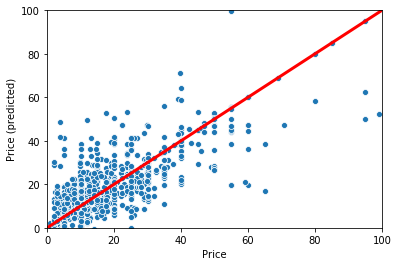

In [12]:
sns.scatterplot(x="Price",y="Price_p",data=df)
plt.xlim(0, 100) #This sets the x-axis limits to (0, 5e10 = 140000000000)
plt.ylim(0, 100) #Ditto for y-axis. I want both axes to have the same length, so we can compare them
plt.plot([0, 100], [0, 100], color='red', lw=3) #This draws the straight red line, you can leave this out if you wish
plt.xlabel("Price")
plt.ylabel("Price (predicted)")
plt.show()

This plot shows that predictions are okay when the price is lower because the dots are further apart the higher the price. We can also conclude the model usually overshoots; so predicts the price too high. 

In [14]:
r2_score(df["Price"], df["Price_p"])

0.6149126612611558

In [15]:
math.sqrt(mean_squared_error(df["Price"], df["Price_p"]))

19.434392208606216

The **R2 is 0.61** which is pretty good, but not fantastic. This means we can predict 61.5% of the variation in the price. When including all the columns the R2 was around -8 which is not good at all and means your model is worse than a basic guess. So I tried to remove a couple columns to get a somewhat high positive R2. (The process can be seen at the beginning of the notebook.)

The **RMSE is 19.43**. This means our typical prediction is off by €19.43 which is quite a lot when trying to predict a price for a clothing piece. Some clothing pieces aren't even worth that much money. 

Based on the poster presentation I tried a different method to see if my **R2** score and **RMSE** would improve.
For this I chose the Random Forest method.

In [35]:
eva = RandomForestRegressor(n_estimators = 1000, random_state = 42)
eva.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [36]:
y_pred = eva.predict(X_train)

In [22]:
df_ev = pd.DataFrame({"Actual":y_train, "Predicted":y_pred})
df_ev

,Actual,Predicted
132,6.50,7.883483
844,15.00,15.928383
756,24.95,22.352277
510,14.95,16.292900
246,2.00,5.221400
...,...,...
715,30.00,25.983755
767,27.50,26.360350
72,25.00,20.212136
235,4.00,4.194590


This is already looking good! I am really with the table I am seeing so far and it looks to me the model with the Random Forest method seems to predict the price so much better! But to be sure I am going to calculate the **R2** and **RMSE** scores again. 

In [29]:
r2_score(df_ev["Actual"], df_ev["Predicted"])

0.9040594447641498

In [27]:
math.sqrt(mean_squared_error(df_ev["Actual"], df_ev["Predicted"]))

9.519080464806917

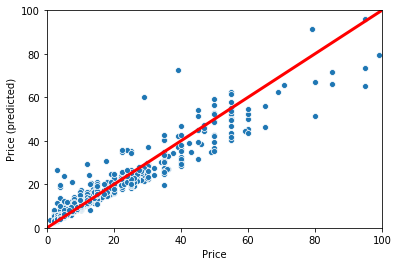

In [33]:
sns.scatterplot(x="Actual",y="Predicted",data=df_ev)
plt.xlim(0, 100) #This sets the x-axis limits to (0, 5e10 = 140000000000)
plt.ylim(0, 100) #Ditto for y-axis. I want both axes to have the same length, so we can compare them
plt.plot([0, 100], [0, 100], color='red', lw=3) #This draws the straight red line, you can leave this out if you wish
plt.xlabel("Price")
plt.ylabel("Price (predicted)")
plt.show()

As you can see the model has improved so much! I am so happy! The plot also shows that the model is really linear. It still overshoots with lower prices and then undershoots at higher prices but overall it's looking quite linear. 

The **R2 is 0.90** which is amazing. This means we can predict 90% of the variation in the price.

The **RMSE is 9.52**. This means our typical prediction is off by €9.52 which is still a lot but €10,- less than with the linear regression model which is a win for me. 

For the practical side of the prediction. The model is definitely not perfect and I wouldn't go solely off this model to calculate the price of your item as there are much more variables involved. For example, the material of the item is not incluced which can play a **HUGE** factor in price. The difference between real and fake leather can be quite insane when looking at a price point of view. So, my advice would be to use this model as a guideline if you absolutely have no clue or if you're just starting to use Vinted. Once you sold a few items you might know better how much each item is worth and can decide your own price based on your experience.